# OpenStreetMap Amenities

In [1]:
%matplotlib inline

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import osmium

for module in [pd, gpd, mpl, ox]:
    print(module.__name__, module.__version__)

pandas 1.4.1
geopandas 0.10.2
matplotlib 3.3.2
osmnx 1.1.2


# Overpass API

- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
- [Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL)
- [Overpass Turbo](https://overpass-turbo.eu/) query editor
- [Loading Data from OpenStreetMap with Python and the Overpass API](https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/)

In [3]:
%%time
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    area["ISO3166-1"="AT"][admin_level=2]->.search;
    (node[amenity="restaurant"](area.search);
     way[amenity="restaurant"](area.search);
     rel[amenity="restaurant"](area.search);
    );
    out count;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

CPU times: user 18.5 ms, sys: 7.73 ms, total: 26.3 ms
Wall time: 49.2 s


{'version': 0.6,
 'generator': 'Overpass API 0.7.57.1 74a55df1',
 'osm3s': {'timestamp_osm_base': '2022-04-02T19:19:13Z',
  'timestamp_areas_base': '2022-04-02T18:30:37Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'count',
   'id': 0,
   'tags': {'nodes': '12874',
    'ways': '6883',
    'relations': '186',
    'areas': '0',
    'total': '19943'}}]}

# Download OpenStreetMap Extract

- __Geofabrik__ ([download.geofabrik.de](http://download.geofabrik.de/))
- __BBBike__ [OSM ready extracts](https://download.bbbike.org/osm/bbbike/)
    - Vienna data set: https://download.bbbike.org/osm/bbbike/Wien/

In [4]:
%%bash
if [ ! -f "data/vienna.osm.pbf" ]; then
    wget https://download.bbbike.org/osm/bbbike/Wien/Wien.osm.pbf \
        --quiet -O data/vienna.osm.pbf
fi

# PyOsmium

- [PyOsmium](https://osmcode.org/pyosmium/)
- [PyOsmium - Documentation](https://docs.osmcode.org/pyosmium/latest/index.html)

In [5]:
from collections import defaultdict

class AmenityStatsHandler(osmium.SimpleHandler):
    def __init__(self):
        super(AmenityStatsHandler, self).__init__()
        self.amenities = defaultdict(int)
    
    def node(self, n):
        for tag in n.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def way(self, w):
        for tag in w.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def relation(self, r):
        for tag in r.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

In [7]:
%%time
src_filepath = "data/vienna.osm.pbf"

handler = AmenityStatsHandler()
handler.apply_file(src_filepath)

s_amenities = pd.Series(handler.amenities)

CPU times: user 3min 23s, sys: 1 s, total: 3min 24s
Wall time: 3min 22s


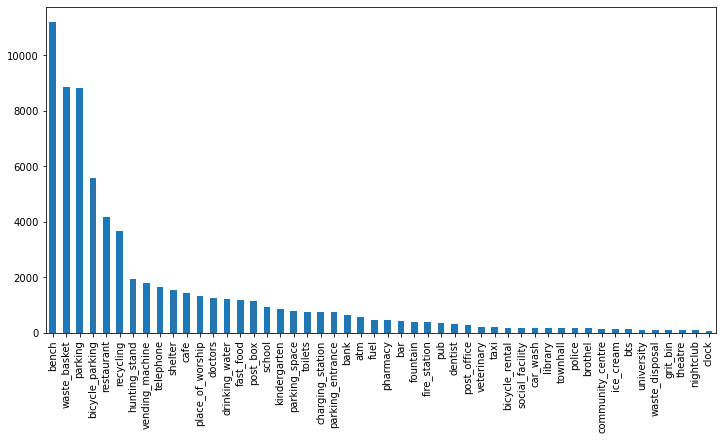

In [8]:
s_amenities.sort_values(ascending=False)[:50] \
  .plot(kind='bar', figsize=(12, 6));

# ogr2ogr

- [ogr2ogr - Documentation](https://gdal.org/programs/ogr2ogr.html)
- [ogr2ogr - OSM - OpenStreetMap XML and PBF](https://gdal.org/drivers/vector/osm.html)

In [9]:
!ogrinfo data/vienna.osm.pbf

INFO: Open of `data/vienna.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [13]:
!which ogr2ogr

/usr/bin/ogr2ogr


In [17]:
%%bash
ogr2ogr -f "GPKG" \
    data/vienna-amenities.gpkg \
    data/vienna.osm.pbf \
    -where "amenity is not null" \
    POINTS \
    -nln amenity

0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
gdf = gpd.read_file("data/vienna-amenities.gpkg", driver='GPKG')
gdf.head(2)

,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,amenity,other_tags,geometry
0,1634625,None,None,None,None,None,None,None,None,recycling,"""recycling:glass_bottles""=>""yes"",""recycling:gr...",POINT (16.29701 48.18111)
1,15079895,None,None,None,None,None,None,None,None,telephone,"""check_date""=>""2022-01-23""",POINT (16.28689 48.19691)


In [19]:
gdf['amenity'].value_counts()[:10]

bench              11063
waste_basket        8861
bicycle_parking     5329
recycling           3421
restaurant          3350
hunting_stand       1910
vending_machine     1795
telephone           1654
cafe                1338
drinking_water      1213
Name: amenity, dtype: int64

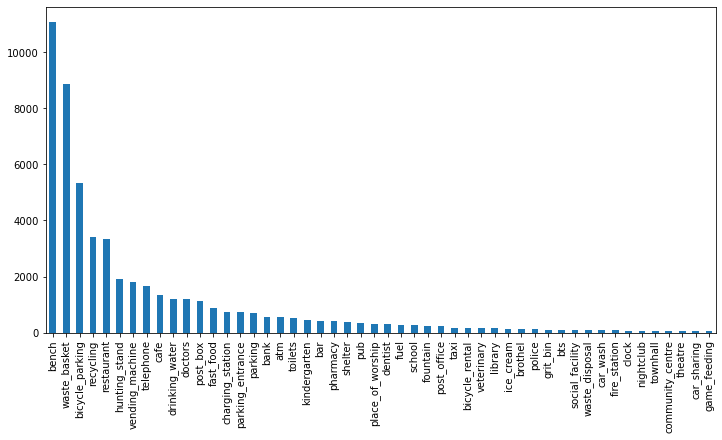

In [20]:
gdf['amenity'].value_counts()[:50].plot(kind='bar', figsize=(12, 6));

# Resources

- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
- [Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL)
- [Overpass Turbo](https://overpass-turbo.eu/) query editor
- [Loading Data from OpenStreetMap with Python and the Overpass API](https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/)
- [PyOsmium](https://osmcode.org/pyosmium/)
- [PyOsmium - Documentation](https://docs.osmcode.org/pyosmium/latest/index.html)
- [ogr2ogr - Documentation](https://gdal.org/programs/ogr2ogr.html)
- [ogr2ogr - OSM - OpenStreetMap XML and PBF](https://gdal.org/drivers/vector/osm.html)